# **Normalized Convolution**

In this notebook we will explore the Normalized Convolution as described in section 3 of this [paper](http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf). Efficent implementation of the approach was inspired by this repository: https://github.com/ericPrince/optical-flow

In [1]:
import scipy
import numpy as np
import cv2
from skimage.data import astronaut
import matplotlib.pyplot as plt
%matplotlib inline

##### Get the test image

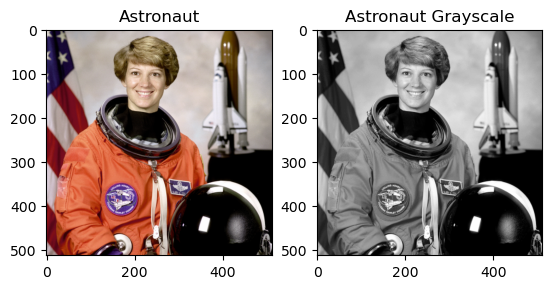

In [2]:
image_rgb = astronaut()
image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

plt.subplot(121)
plt.imshow(image_rgb)
plt.title("Astronaut");

plt.subplot(122)
plt.imshow(image, cmap='gray')
plt.title("Astronaut Grayscale");

#### Next we will randomly sample a percentage of pixels in the image to simulate a degraded image. The portion of pixels to randonly sample is denoted by $\alpha$.

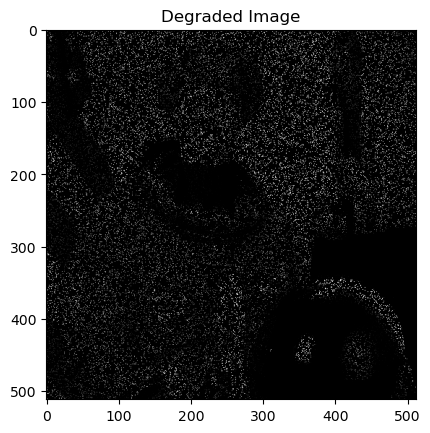

In [39]:
alpha = 0.1 # probability of selecting a pixel
rng = np.random.default_rng()
mask = rng.choice([0,1], size=image.shape, p=[1 - alpha, alpha])

degraded_image = image.copy()
degraded_image[mask == 0] = 0

plt.imshow(degraded_image, cmap='gray')
plt.title("Degraded Image");

### Now let's implement a Regular Smoothing Convolution to restore this image

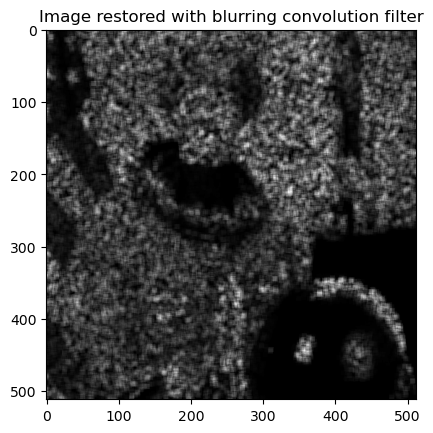

In [40]:
# Apply blurring kernel
kernel = np.ones((7, 7), np.float32) / 25
blurred = cv2.filter2D(src=degraded_image, ddepth=-1, kernel=kernel)

plt.imshow(blurred, cmap='gray')
plt.title("Image convolved with blurring convolution filter");

Using a regular convolution does not work very well. This is because no compensation is made for the variation in local sampling density.


### Now let's implement Normalized Convolution

In [177]:
def normalized_convolution(f: np.ndarray, c: np.ndarray, a: np.ndarray,
                           bx: np.ndarray, by: np.ndarray)-> np.ndarray:
    """ Computes Normalized Convolution and returns the coefficients r as well as 
        The polynomial basis functions in the x and y dimensions. For the efficieny,
        the computations are implemented as separable convolutions. 

        Inputs: 
            f  - signal (assumed to be an NxM array)
            c  - signal certainty (same shape as the signal)
            a  - (nxn) applicability kernel for each pixel
            bx - x-dimension basis functions of predefined polynomial order
            by - y-dimension basis functions of predefined polynomial order

        Outputs
            r - Computed Coefficients --> parameterization for input polynomial basis functions
            
        References:
            [1]    G. Farneback, “Polynomial Expansion for Orientation and Motion Estimation,” 
            Ph.D. dissertation, Inst. of  Technology, Linköping Univ., Norrköping, Sweden, 2002. 
            [Online]. Available: http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf
            (Chapter 3)
        """
    # get dimensionality of applicability
    n = a.shape[0]

    # reshape applicability kernel
    a = a.reshape(-1)

    # Pre-calculate product of certainty and signal
    cf = c * f

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper
    ab_x = np.einsum("i,ij->ij", a, bx)
    abb_x = np.einsum("ij,ik->ijk", ab_x, bx)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb_x[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab_x[..., i], axis=0, mode="constant", cval=0
        )

    
    # Pre-calculate quantities recommended in paper
    ab_y = np.einsum("i,ij->ij", a, by)
    abb_y = np.einsum("ij,ik->ijk", ab_y, by)

    # Calculate G and v for each pixel with cross-correlation
    # Note that these are of the form x = x*b or x *= b
    # We have already included the c and cf terms in the x-dim computation
    for i in range(by.shape[-1]):
        for j in range(by.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                G[..., i, j], abb_y[..., i, j], axis=1, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            v[..., i], ab_y[..., i], axis=1, mode="constant", cval=0
        )

    # if G is singular, then we will need to reduce the singularity 
    # if np.any(~np.isfinite(np.linalg.cond(G))):
    #     print("Warning! Singular Matrix! Adding perturbation!")
    #     # add a small Normal perturbation to reduce singularity of G
    #     G += np.random.normal(loc=0, scale=0.001, size=G.shape)

    # Solve r for each pixel
    try:
        r = np.linalg.solve(G, v)
    except np.linalg.LinAlgError as err:
        print(err)
        print("Adding Perturbation!")

        # p = np.eye(G.shape[0])*np.random.normal(loc=0, scale=0.001, size=G.shape[0])
        # p = np.repeat(p[:, :, None], G.shape[-1], axis=-1)
        # p = np.repeat(p[:, :, :, None], G.shape[-1], axis=-1)

        p = np.random.normal(loc=0, scale=0.001, size=G.shape)
        r = np.linalg.solve(G + p, v)

    return r

In [ ]:
# get applicability
a = np.array([
    [1, 1, 2, 1, 1],
    [1, 2, 4, 2, 1],
    [2, 4, 7, 4, 2],
    [1, 2, 4, 2, 1],
    [1, 1, 2, 1, 1]
])


# get basis x-dim and y-dim functions for: {1, x, y, x2, xy, y2}
n = a.shape[0]
b = np.repeat(np.c_[np.arange(-(n-1)//2, (n+1)//2)], 
                n, axis=-1).T

# x dimension (set y=1)
bx = np.vstack((
    np.ones((n**2)),    # 1
    b.T.reshape(-1),    # x
    np.ones((n**2)),    # y
    b.T.reshape(-1)**2, # x^2
    b.T.reshape(-1),    # xy
    np.ones((n**2)),    # y^2
)).T

# y dimension (set x=1)
by = np.vstack((
    np.ones((n**2)),  # 1
    np.ones((n**2)),  # x
    b.reshape(-1),    # y
    np.ones((n**2)),  # x^2
    b.reshape(-1),    # xy
    b.reshape(-1)**2, # y^2
)).T


r = normalized_convolution(degraded_image, mask, a, bx, by)

In [43]:
# possible delete    
def get_convolved_image(r, bx, by):
    """ Obtains convolved image from Normalized Convolution
        Inputs:
            bx - x-dimension basis functions of predefined polynomial order
            by - y-dimension basis functions of predefined polynomial order 
            shape - shape of original image
        """
    fx = np.zeros(r.shape).astype(np.float64)
    fy = np.zeros(r.shape).astype(np.float64)

    for i in range(bx.shape[1]):
        fx[..., i] = scipy.ndimage.correlate1d(
                    r[..., i], np.float64(bx[:, i]), axis=0, mode="constant", cval=0
                )

    # axis = 0 for y axis?
    for i in range(by.shape[1]):
        fy[..., i] = scipy.ndimage.correlate1d(
                    r[..., i], by[:, i], axis=1, mode="constant", cval=0
                )
        
    return fx, fy

Plot the result of the Normalized Convolution. We will only plot the DC Basis function. Note that the higher level Basis functions contain image gradients that provide useful information for possiblt further reconstruction.

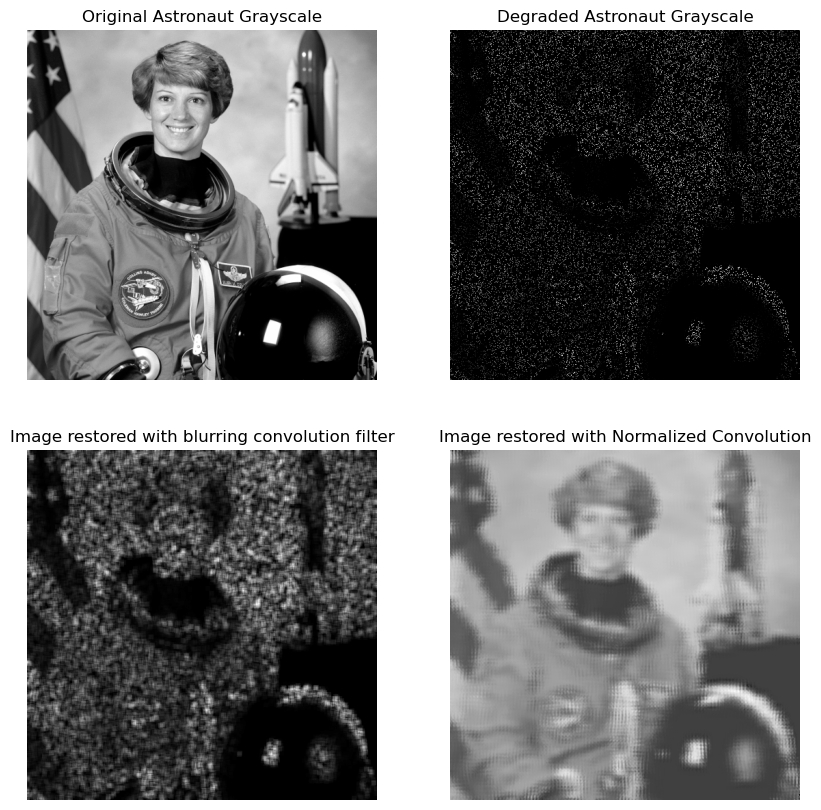

In [44]:
nc_result = cv2.normalize(r[:, :, 0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(image, cmap='gray')
plt.title("Original Astronaut Grayscale");
plt.axis(False)

plt.subplot(222)
plt.imshow(degraded_image, cmap='gray')
plt.title("Degraded Astronaut Grayscale");
plt.axis(False)

plt.subplot(223)
plt.imshow(blurred, cmap='gray')
plt.title("Convolved with blurring convolution filter");
plt.axis(False)

plt.subplot(224)
plt.imshow(nc_result, cmap='gray')
plt.title("Normalized Convolution");
plt.axis(False);

# Normalized Averaging

Now apply Normalized Averaging to restore the image. For the Normalized Averaging we will design an Applicability Kernel to convolve the degraded image with. In this case we will try a basic Gaussian and a more localized Kernel and compare the results. To compute the Normalized Average, we will first Convolve the applicability kernel with image (with certainty) and then divide the result by the convolution of the Certainty with the Applicability Kernel.

$$ \mathbb{n} = \frac{a * cf}{a * c} $$

In [293]:
appl_fun = np.vectorize(lambda x: 0.5*x**(-3) if ((abs(x) > 1) and (abs(x) < 10)) else 1) # local Kernel
appl_fun_gaus = np.vectorize(lambda x, sig=1.2: (1/(sig*2*np.pi))*np.exp((-x**2)/(2*sig))) # Gaussian Kernel

def cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True):
    complex_format = x - x_c + 1j * (y - y_c)
    return np.abs(complex_format), np.angle(complex_format, deg = deg)

In [294]:
n = 11
x, y = np.mgrid[-(n-1)//2:(n+1)//2, -(n-1)//2:(n+1)//2]
rho, theta = cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True)

Text(0.5, 1.0, 'Gaussian Applicability Kernel')

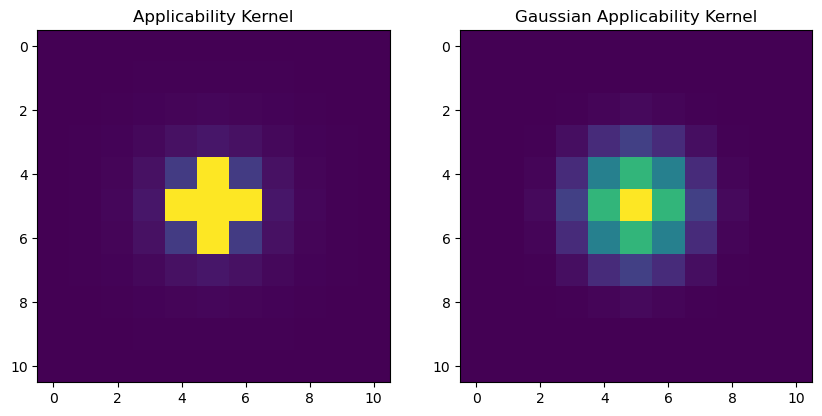

In [295]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(appl_fun(rho))
plt.title("Applicability Kernel")

plt.subplot(122)
plt.imshow(appl_fun_gaus(rho))
plt.title("Gaussian Applicability Kernel")

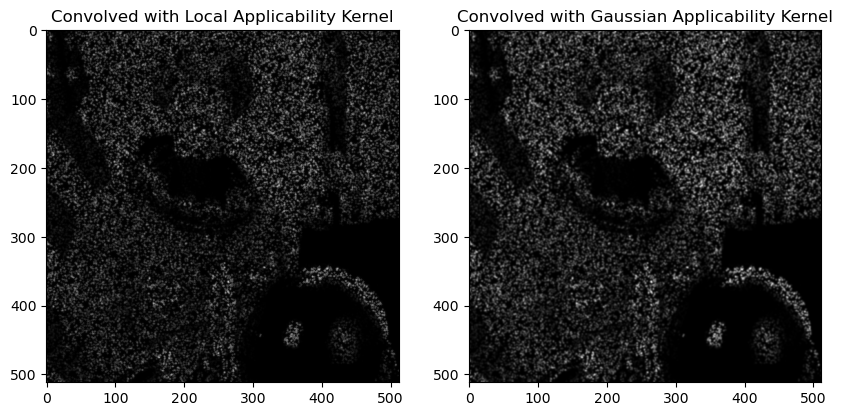

In [314]:
# get Applicability Kernels
a = appl_fun(rho)
a_gaus = appl_fun_gaus(rho)

# convolve image with applicability kernel
# NOTE: degraded_image already has the certainty applied
degraded_image_norm = cv2.normalize(degraded_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
af = cv2.filter2D(src=degraded_image_norm, ddepth=-1, kernel=a)
af_gaus = cv2.filter2D(src=degraded_image_norm, ddepth=-1, kernel=a_gaus)


# display 
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(af, cmap='gray')
plt.title("Convolved with Local Applicability Kernel");

plt.subplot(122)
plt.imshow(af_gaus, cmap='gray')
plt.title("Convolved with Gaussian Applicability Kernel");

#### Convolve Certainty with Applicability to get the divisor

In [297]:
# normalize the certainty (aka mask)
mask_norm = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
ca = cv2.filter2D(src=mask_norm , ddepth=-1, kernel=a)
ca_gaus = cv2.filter2D(src=mask_norm , ddepth=-1, kernel=a_gaus)

#### Perform Normalized Averaging

In [298]:
na = af/ca
na_gaus = af_gaus/ca_gaus

C:\Users\itber\AppData\Local\Temp\ipykernel_20128\2343352005.py:1: RuntimeWarning: invalid value encountered in divide
  na = af/ca
C:\Users\itber\AppData\Local\Temp\ipykernel_20128\2343352005.py:2: RuntimeWarning: invalid value encountered in divide
  na_gaus = af_gaus/ca_gaus


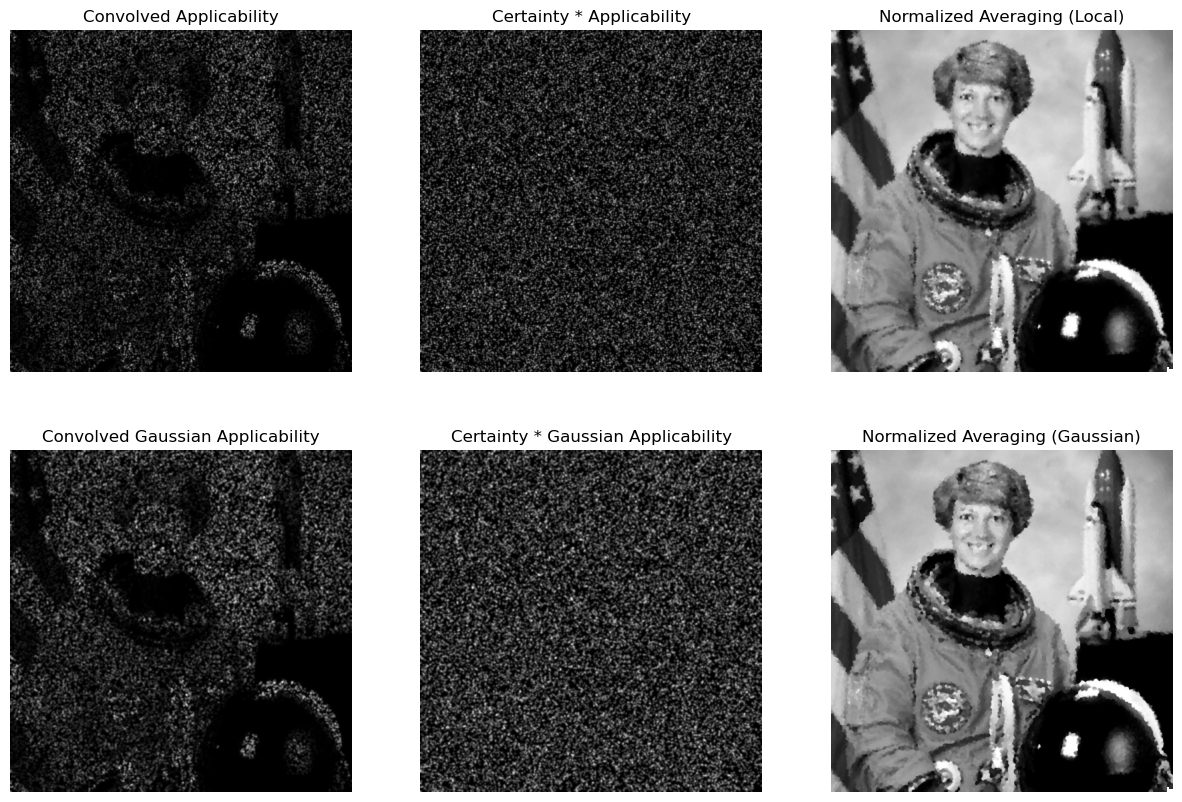

In [316]:

plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.title("Convolved Applicability")
plt.imshow(af, cmap='gray')
plt.axis(False)

plt.subplot(232)
plt.title("Certainty * Applicability")
plt.imshow(ca, cmap='gray')
plt.axis(False)

plt.subplot(233)
plt.title("Normalized Averaging (Local)")
plt.imshow(na, cmap='gray')
plt.axis(False)

plt.subplot(234)
plt.title("Convolved Gaussian Applicability")
plt.imshow(af_gaus, cmap='gray')
plt.axis(False)

plt.subplot(235)
plt.title("Certainty * Gaussian Applicability")
plt.imshow(ca_gaus, cmap='gray')
plt.axis(False)

plt.subplot(236)
plt.title("Normalized Averaging (Gaussian)")
plt.imshow(na_gaus, cmap='gray')
plt.axis(False);

# Visualize Final Results

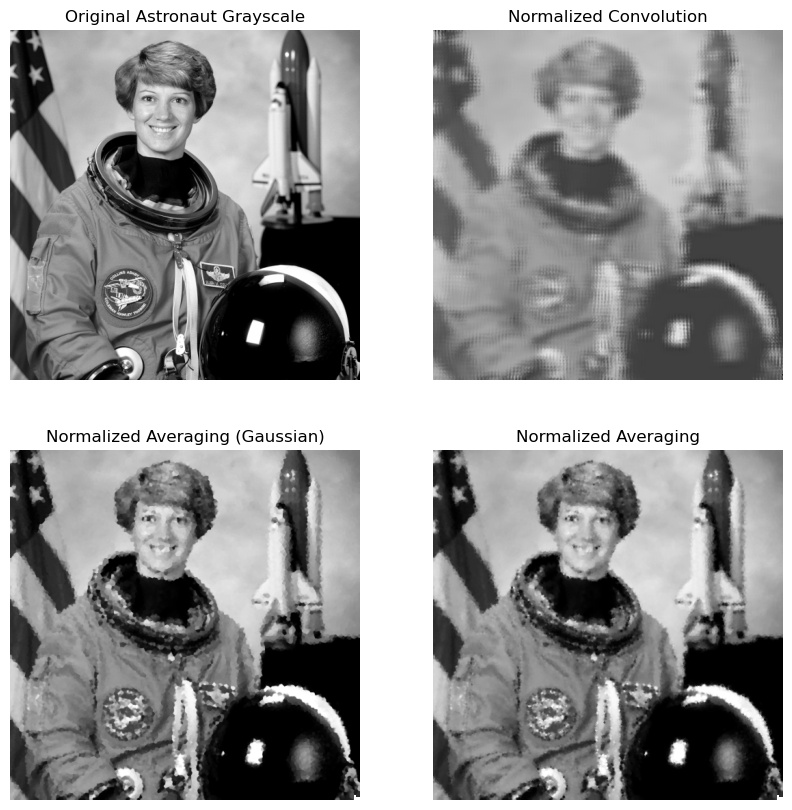

In [312]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("Original Astronaut Grayscale");
plt.imshow(image, cmap='gray')
plt.axis(False)

plt.subplot(222)
plt.imshow(nc_result, cmap='gray')
plt.title("Normalized Convolution");
plt.axis(False)

plt.subplot(223)
plt.title("Normalized Averaging (Gaussian)")
plt.imshow(na_gaus, cmap='gray')
plt.axis(False)

plt.subplot(224)
plt.title("Normalized Averaging (Local)")
plt.imshow(na, cmap='gray')
plt.axis(False);

#### Compare the original image with the restored image

In [326]:
# remove NaNs
na[np.isnan(na)] = 0

# normalize image
image_norm = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# compute delta
delta = image_norm - na

Text(0.5, 1.0, 'Delta between original image and Normalized Average')

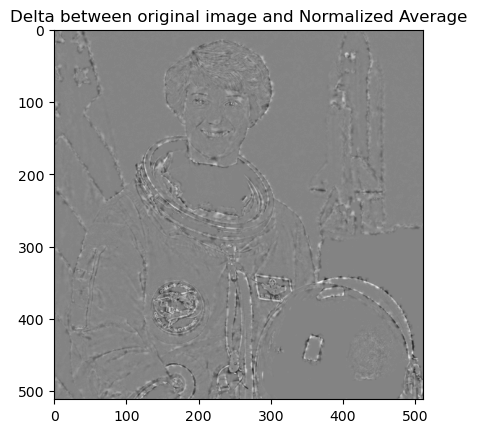

In [327]:
plt.imshow(delta, cmap='gray')
plt.title("Delta between original image and Normalized Average")

## Make a pipeline to compute Normalized Averaing

### Compute with RGB image

This time we will use an even greater undersampling

In [354]:
alpha = 0.0125
mask = rng.choice([0,1], size=image.shape, p=[1 - alpha, alpha])

rgb_mask = np.repeat(mask[:, :, None], 3, axis=-1)
degraded_image_rgb = image_rgb * rgb_mask

In [355]:
# compute numerator
degraded_image_rgb_norm = cv2.normalize(degraded_image_rgb, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
af_rgb = cv2.filter2D(src=degraded_image_rgb_norm, ddepth=-1, kernel=a)

# compute denomentor
rgb_mask_norm = cv2.normalize(rgb_mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
ca_rgb = cv2.filter2D(src=rgb_mask_norm , ddepth=-1, kernel=a)

# compute Normalized Convolution
na_rgb = af_rgb / ca_rgb

C:\Users\itber\AppData\Local\Temp\ipykernel_20128\1231270932.py:10: RuntimeWarning: invalid value encountered in divide
  na_rgb = af_rgb / ca_rgb


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

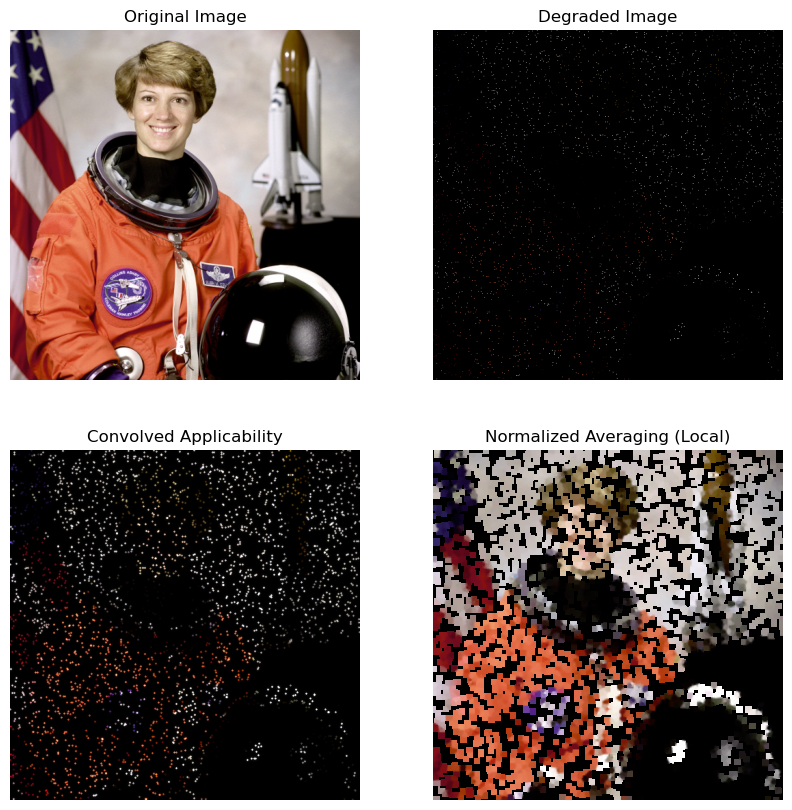

In [356]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis(False)

plt.subplot(222)
plt.title("Degraded Image")
plt.imshow(degraded_image_rgb)
plt.axis(False)

plt.subplot(223)
plt.title("Convolved Applicability")
plt.imshow(af_rgb)
plt.axis(False)

plt.subplot(224)
plt.title("Normalized Averaging (Local)")
plt.imshow(na_rgb)
plt.axis(False)

$ r = (B^* W_a W_c B)^{-1} B^* W_a W_c f $

### Reconstruct the signal with
$ \hat{f} = Br $

 [1]    G. Farneback, “Polynomial Expansion for Orientation and Motion Estimation,” Ph.D. dissertation, Inst. of Technology, Linköping Univ., Norrköping, Sweden, 2002. [Online]. Available: http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf

 [2] Signal Processing for Computer Vision